In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
import pei.laborfunctions as lf
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from dask.diagnostics import ProgressBar
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
plt.style.use('/home/aos/kyan/.config/matplotlib/esm2m.mplstyle')

# Load Data

## ESM2M

In [32]:
# Population data
ds_pop_esm2m = xr.open_dataset('../data/processed/GFDL/population_regrid_esm2m_2.nc')['population']
ds_pop_esm2m = ds_pop_esm2m.where(np.isfinite(ds_pop_esm2m),0)

In [33]:
# Load area data
land_area_esm2m = xr.open_dataset('../data/processed/GFDL/esm2m.land_area')['land_area']
land_mask = np.isfinite(land_area_esm2m)
# Replace NaN with 0 
land_area_esm2m = land_area_esm2m.where(land_mask,0)

In [34]:
# Load temp and WBGT data
tref_summer_esm2m = xr.open_dataarray('../data/processed/GFDL/Map_Data/tref_summer_ens1-30.nc')
wbgt_summer_esm2m = xr.open_dataarray('../data/processed/GFDL/Map_Data/wbgt_summer_ens1-30.nc')

## CESM2

In [8]:
# Population data
ds_pop_cesm2 = xr.open_dataset('../data/processed/CESM2/population_regrid_cesm2_2.nc')['population']
ds_pop_cesm2 = ds_pop_cesm2.where(np.isfinite(ds_pop_cesm2),0)

In [9]:
land_area_cesm2 = xr.open_dataset('../data/processed/CESM2/cesm2.land_area')['__xarray_dataarray_variable__']
land_mask = np.isfinite(land_area_cesm2)
# Replace NaN with 0 
land_area_cesm2 = land_area_cesm2.where(land_mask,0).isel(ensemble=0)

In [10]:
# Load temp and WBGT data
tref_summer_cesm2 = xr.open_dataarray('../data/processed/CESM2/Map_Data/tref_summer_ens1-30.nc')
wbgt_summer_cesm2 = xr.open_dataarray('../data/processed/CESM2/Map_Data/wbgt_summer_ens1-30.nc')

# Process Data

## ESM2M

In [6]:
# Temp and WBGT data
tref_esm2m = xr.open_dataarray('../data/processed/GFDL/Map_Data/tref_seasonal_ens1-30.nc',chunks={'time':1095})
wbgt_esm2m = xr.open_dataarray('../data/processed/GFDL/Map_Data/wbgt_seasonal_ens1-30.nc',chunks={'time':1095})

In [3]:
def summer_avg(ds):
    '''Function to get annual summertime average'''
    # Summer average for Northern hemisphere
    ds_north = ds.where(ds['lat']>=0,drop=True)
    ds_north = ds_north.sel(time=(ds_north['time.month'] == 8))
    
    # Summer average for Southern hemisphere
    ds_south = ds.where(ds['lat']<0,drop=True)
    ds_south = ds_south.sel(time=(ds_south['time.month'] == 2))
    
    # Join Northern and Southern
    ds_summer = xr.concat([ds_south,ds_north],dim='lat')
    
    # Reduce coord from time to year
    ds_summer = ds_summer.groupby('time.year').sum()
    
    return ds_summer

In [8]:
with ProgressBar():
    tref_summer_esm2m = (summer_avg(tref_esm2m) - 273.15).compute()
    wbgt_summer_esm2m = summer_avg(wbgt_esm2m).compute()

[########################################] | 100% Completed |  8.1s
[########################################] | 100% Completed |  1min 26.7s


## CESM2

In [2]:
# Temp and WBGT data
tref_cesm2 = xr.open_dataarray('../data/processed/CESM2/Map_Data/tref_seasonal_ens1-30.nc',chunks={'time':1095})
wbgt_cesm2 = xr.open_dataarray('../data/processed/CESM2/Map_Data/wbgt_seasonal_ens1-30.nc',chunks={'time':1095})

In [4]:
with ProgressBar():
    tref_summer_cesm2 = (summer_avg(tref_cesm2) - 273.15).compute()
    wbgt_summer_cesm2 = summer_avg(wbgt_cesm2).compute()

[########################################] | 100% Completed |  4min 58.6s
[########################################] | 100% Completed |  4min 59.4s


In [6]:
tref_summer_cesm2.to_netcdf('../data/processed/CESM2/Map_Data/tref_summer_ens1-30.nc')
wbgt_summer_cesm2.to_netcdf('../data/processed/CESM2/Map_Data/wbgt_summer_ens1-30.nc')

# Maps

In [15]:
def plot_compare(tref_hist,tref_future,wbgt_hist,wbgt_future,title):
    # Specify projection
    crs = ccrs.Robinson()

    # Create figure and axes
    fig, axs = plt.subplots(ncols=3,nrows=2,figsize=(16,8),subplot_kw={'projection':crs},gridspec_kw={'width_ratios': [0.1,3,3]})
    levels_temp = np.linspace(20,40,9)
    levels_wbt = np.linspace(20,30,9)

    # Plot temp maps
    im1 = lf.contour(tref_hist,'\n1980-2000 Summertime Mean\n',axs[0][1],levels=levels_temp,cmap='Reds',label='t_ref',over=None,crop=True)
    lf.contour(tref_future,'\n2080-2100 Summertime Mean\n',axs[0][2],levels=levels_temp,cmap='Reds',label='t_ref',over=None,crop=True)

    # Plot WBGT maps
    im2 = lf.contour(wbgt_hist,None,axs[1][1],levels=levels_wbt,cmap='RdPu',label='Temperature',over=None,crop=True)
    lf.contour(wbgt_future,None,axs[1][2],levels=levels_wbt,cmap='RdPu',label='WBT',over=None,crop=True)

    # Make room for colorbars on right side
    fig.subplots_adjust(right=0.85)
    
    # Add colorbar for temp
    cbar_ax1 = fig.add_axes([0.875, 0.55, 0.02, 0.3])
    cbar = fig.colorbar(im1, cax=cbar_ax1, orientation='vertical',format='%.1f');
    cbar.set_label('\t$^\circ$C',fontsize=22,rotation=0)
    cbar.set_ticks(np.linspace(20,40,5))

    # Add colorbar for WBGT
    cbar_ax2 = fig.add_axes([0.875, 0.174, 0.02, 0.3])
    cbar = fig.colorbar(im2, cax=cbar_ax2, orientation='vertical');
    cbar.set_label('\t$^\circ$C',fontsize=22,rotation=0)
    cbar.set_ticks(np.linspace(20,30,5))
    
    # Annotating text
    axs[0][0].text(0.5,0.5,'$T_{ref}$',fontsize=22,horizontalalignment='right',verticalalignment='center');
    axs[0][0].set_frame_on(False)
    axs[1][0].text(0.5,0.5,'$WBGT$',fontsize=22,horizontalalignment='right',verticalalignment='center');
    axs[1][0].set_frame_on(False)

    fig.subplots_adjust(wspace=.02,hspace=.05)
    fig.suptitle(title,fontweight='bold');

## ESM2M

In [15]:
tref_hist = tref_summer_esm2m.sel(year=slice(1980,1999)).mean(['year','ensemble'])
tref_future = tref_summer_esm2m.sel(year=slice(2080,2099)).mean(['year','ensemble'])

wbgt_hist = wbgt_summer_esm2m.sel(year=slice(1980,1999)).mean(['year','ensemble'])
wbgt_future = wbgt_summer_esm2m.sel(year=slice(2080,2099)).mean(['year','ensemble'])

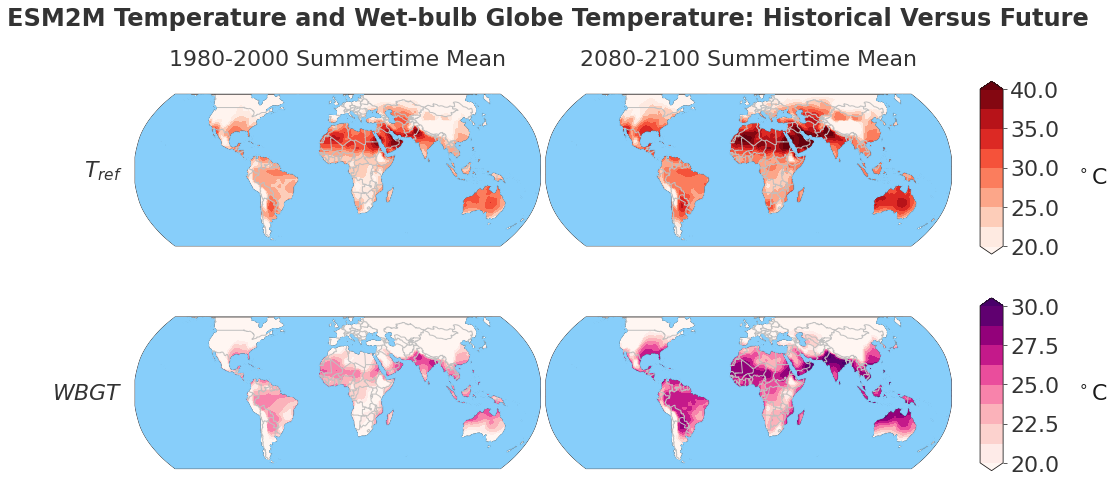

In [23]:
plot_compare(tref_hist,tref_future,wbgt_hist,wbgt_future,'ESM2M Temperature and Wet-bulb Globe Temperature: Historical Versus Future')
plt.savefig('temp_wbgt_map_esm2m.png',dpi=300)

## CESM2

In [11]:
tref_hist = tref_summer_cesm2.sel(year=slice(1980,1999)).mean(['year','ensemble'])
tref_future = tref_summer_cesm2.sel(year=slice(2080,2099)).mean(['year','ensemble'])

wbgt_hist = wbgt_summer_cesm2.sel(year=slice(1980,1999)).mean(['year','ensemble'])
wbgt_future = wbgt_summer_cesm2.sel(year=slice(2080,2099)).mean(['year','ensemble'])

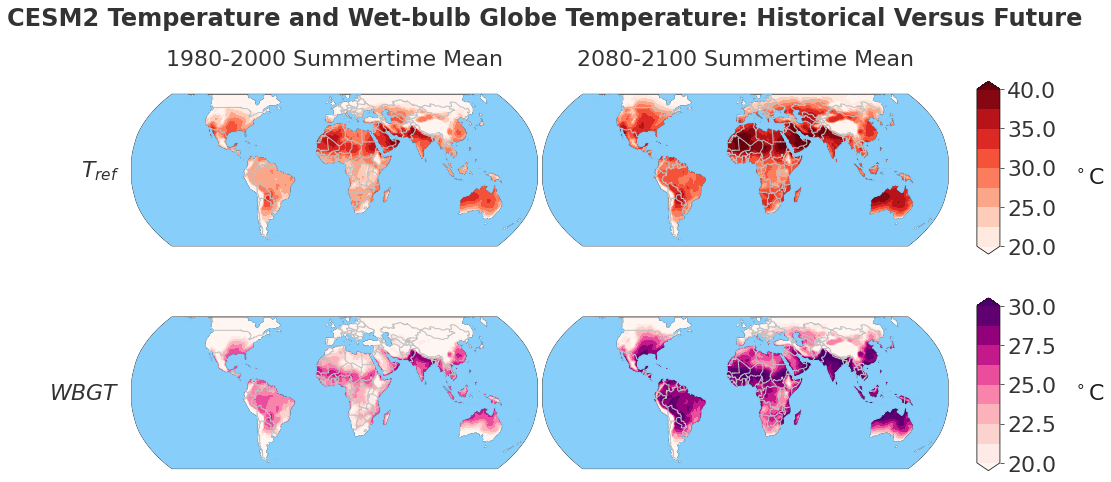

In [16]:
plot_compare(tref_hist,tref_future,wbgt_hist,wbgt_future,'CESM2 Temperature and Wet-bulb Globe Temperature: Historical Versus Future')
plt.savefig('temp_wbgt_map_cesm2.png',dpi=300)

In [18]:
def plot_diff(tref_hist,tref_future,wbgt_hist,wbgt_future,title):
    # Specify projection
    crs = ccrs.Robinson()
    levels=np.linspace(1,5,9)
    cmap='YlOrRd'

    # Create figure and axes
    fig, axs = plt.subplots(ncols=2,figsize=(16,4.5),subplot_kw={'projection':crs})

    im1 = lf.contour(tref_future-tref_hist,'$\Delta T_{ref}$',axs[0],levels=levels,cmap=cmap,label='t_ref',over=None,crop=True)
    lf.contour(wbgt_future-wbgt_hist,'$\Delta WBGT$',axs[1],levels=levels,cmap=cmap,label='t_ref',over=None,crop=True)
    
    # Single colorbar for all plots
    fig.subplots_adjust(bottom=0.2)
    cbar_ax = fig.add_axes([0.3, 0.15, 0.4, 0.075])
    cbar = fig.colorbar(im1, cax=cbar_ax,orientation='horizontal',format='%.1f');
    cbar.set_label('$^\circ$C',fontsize=22)
    cbar.set_ticks(np.linspace(1,5,5))
    
    fig.subplots_adjust(wspace=.02)
    
    fig.suptitle(title,fontweight='bold')

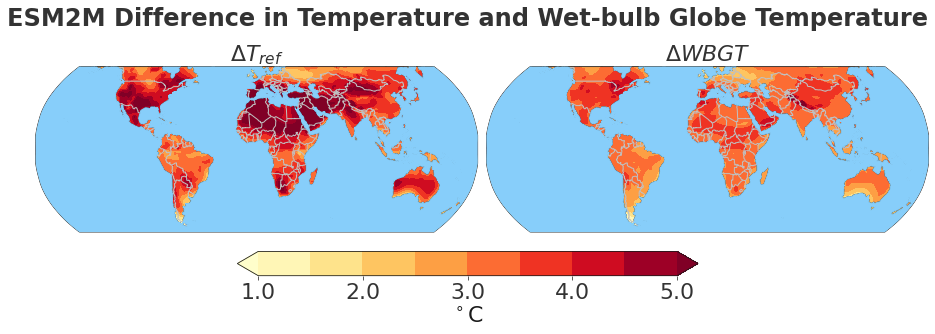

In [28]:
plot_diff(tref_hist,tref_future,wbgt_hist,wbgt_future,'ESM2M Difference in Temperature and Wet-bulb Globe Temperature')
plt.savefig('temp_wbgt_diff_esm2m.png',dpi=300)

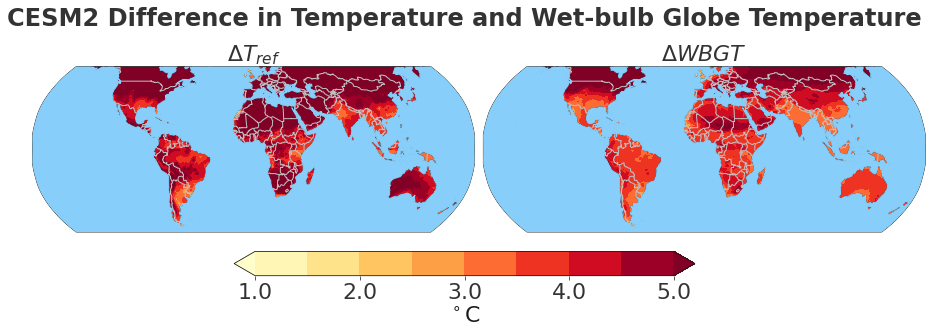

In [19]:
plot_diff(tref_hist,tref_future,wbgt_hist,wbgt_future,'CESM2 Difference in Temperature and Wet-bulb Globe Temperature')
plt.savefig('temp_wbgt_diff_cesm2.png',dpi=300)

# Time Series

In [28]:
def plot_series(global_tref,global_wbgt,regional_tref,regional_wbgt,title):
    # Create figure and axes
    fig,ax=plt.subplots(figsize=(16,10))

    # Ensemble spread for global temp and WBGT
    ax.fill_between(global_tref['year'],global_tref.min('ensemble'),global_tref.max('ensemble'),alpha=0.15,color='red')
    ax.fill_between(global_wbgt['year'],global_wbgt.min('ensemble'),global_wbgt.max('ensemble'),alpha=0.15,color='purple')

    # Ensemble spread for regional temp and WBGT
    ax.fill_between(regional_tref['year'],regional_tref.min('ensemble'),regional_tref.max('ensemble'),alpha=0.4,facecolor='none',hatch='//',edgecolor='red',linewidth=1.5)
    ax.fill_between(regional_wbgt['year'],regional_wbgt.min('ensemble'),regional_wbgt.max('ensemble'),alpha=0.4,facecolor='none',hatch='//',edgecolor='purple',linewidth=1.5)

    # Ensemble mean for temp
    global_tref.mean('ensemble').plot(ax=ax,color='red',linewidth=3)
    regional_tref.mean('ensemble').plot(ax=ax,color='red',linestyle='dotted',linewidth=3)

    # Ensemble mean for WBGT
    global_wbgt.mean('ensemble').plot(ax=ax,color='purple',linewidth=3)
    regional_wbgt.mean('ensemble').plot(ax=ax,color='purple',linestyle='dotted',linewidth=3)

    ax.set_xlim([1980,2100])
    ax.set_ylim([12,35])
    ax.set_xlabel('Year',fontweight='bold')
    ax.set_ylabel('$^\circ$C\t',rotation=0,fontweight='bold')

    # Legend handles
    red_patch = mpatches.Patch(color='red', label='$T_{ref}$')
    purple_patch = mpatches.Patch(color='purple', label='$WBGT$')

    solid_line = mlines.Line2D([], [], color='black', linestyle='solid', label='Global mean')
    dot_line = mlines.Line2D([], [], color='black', linestyle='dotted', label='45S - 45N mean')

    solid_patch = mpatches.Patch(color='black', label='Global ensemble range')
    hatch_patch = mpatches.Patch(fill=False, hatch='//', color='black', label='45S - 45N ensemble range')

    # Set legend
    ax.legend(handles=[red_patch,purple_patch,dot_line,solid_line,hatch_patch,solid_patch],ncol=3,loc='lower center',bbox_to_anchor=(0.5,0.95));

    ax.set_title(title,fontsize=24,fontweight='bold');

## ESM2M

In [35]:
# Global area-weighted temp and WBGT
global_tref_esm2m = tref_summer_esm2m.weighted(land_area_esm2m).mean(['lat','lon'])
global_wbgt_esm2m = wbgt_summer_esm2m.weighted(land_area_esm2m).mean(['lat','lon'])

# Regional area-weighted temp (45S to 45N)
regional_tref_esm2m = tref_summer_esm2m.sel(lat=slice(-45,45))
regional_tref_esm2m = regional_tref_esm2m.weighted(land_area_esm2m).mean(['lat','lon'])

# Regional area-weighted WBGT
regional_wbgt_esm2m = wbgt_summer_esm2m.sel(lat=slice(-45,45))
regional_wbgt_esm2m = regional_wbgt_esm2m.weighted(land_area_esm2m).mean(['lat','lon'])

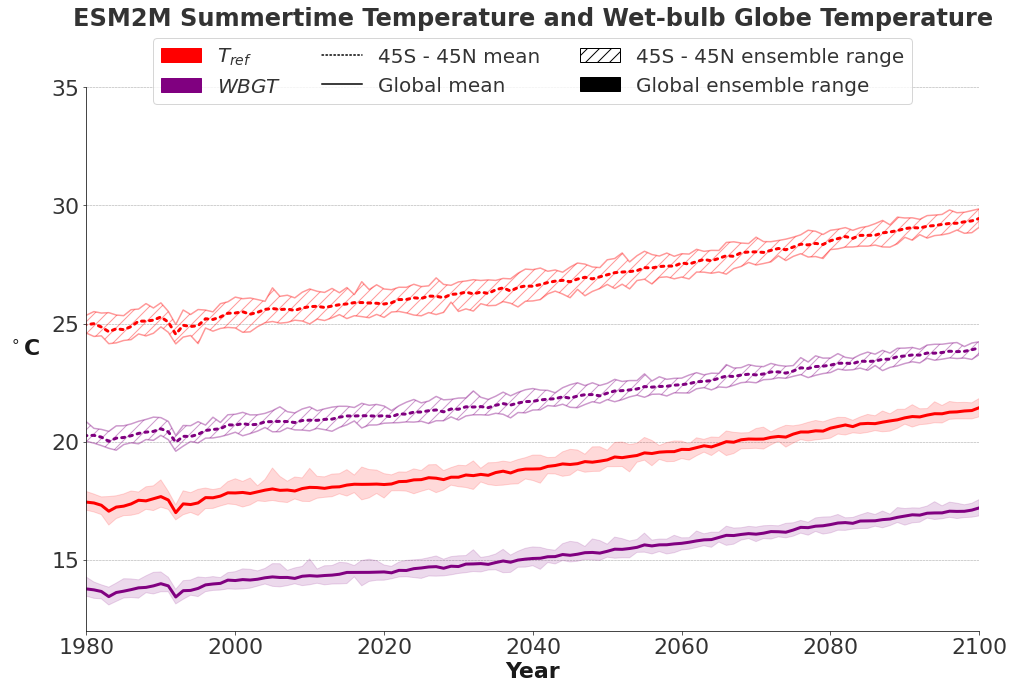

In [36]:
plot_series(global_tref_esm2m,global_wbgt_esm2m,regional_tref_esm2m,regional_wbgt_esm2m,'ESM2M Summertime Temperature and Wet-bulb Globe Temperature\n\n')
plt.savefig('temp_wbgt_timeseries_esm2m.png',dpi=300)

## CESM2

In [30]:
# Global area-weighted temp and WBGT
global_tref_cesm2 = tref_summer_cesm2.weighted(land_area_cesm2).mean(['lat','lon']).isel(year=slice(0,-1))
global_wbgt_cesm2 = wbgt_summer_cesm2.weighted(land_area_cesm2).mean(['lat','lon']).isel(year=slice(0,-1))

# Regional area-weighted temp (45S to 45N)
regional_tref_cesm2 = tref_summer_cesm2.sel(lat=slice(-45,45))
regional_tref_cesm2 = regional_tref_cesm2.weighted(land_area_cesm2).mean(['lat','lon']).isel(year=slice(0,-1))

# Regional area-weighted WBGT
regional_wbgt_cesm2 = wbgt_summer_cesm2.sel(lat=slice(-45,45))
regional_wbgt_cesm2 = regional_wbgt_cesm2.weighted(land_area_cesm2).mean(['lat','lon']).isel(year=slice(0,-1))

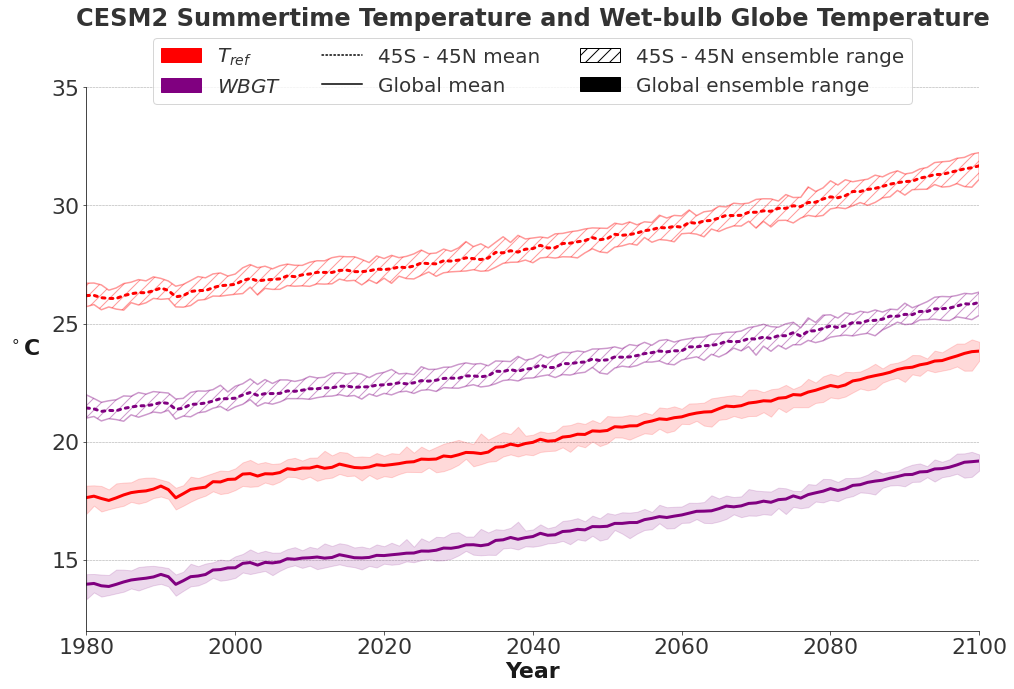

In [31]:
plot_series(global_tref_cesm2,global_wbgt_cesm2,regional_tref_cesm2,regional_wbgt_cesm2,'CESM2 Summertime Temperature and Wet-bulb Globe Temperature\n\n')
plt.savefig('temp_wbgt_timeseries_cesm2.png',dpi=300)